<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/tutorials/W2D2_LinearSystems/student/W2D2_Tutorial2.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W2D2_LinearSystems/student/W2D2_Tutorial2.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>

# Tutorial 2: Markov Processes

**Week 2, Day 2: Linear Systems**

**By Neuromatch Academy**

**Content Creators**: Bing Wen Brunton, Ellie Stradquist

**Content Reviewers**: Norma Kuhn, Karolina Stosio, John Butler, Matthew Krause, Ella Batty, Richard Gao, Michael Waskom, Ethan Cheng

**Production editors:** Gagana B, Spiros Chavlis

---
# Tutorial Objectives

*Estimated timing of tutorial: 45 minutes*

In this tutorial, we will look at the dynamical systems introduced in the first tutorial through a different lens.

In Tutorial 1, we studied dynamical systems as a deterministic process. For Tutorial 2, we will look at **probabilistic** dynamical systems. You may sometimes hear these systems called _stochastic_. In a probabilistic process, elements of randomness are involved. Every time you observe some probabilistic dynamical system, starting from the same initial conditions, the outcome will likely be different. Put another way, dynamical systems that involve probability will incorporate random variations in their behavior.

For some probabilistic dynamical systems, the differential equations express a relationship between $\dot{x}$ and $x$ at every time $t$, so that the direction of $x$ at _every_ time depends entirely on the value of $x$. Said a different way, knowledge of the value of the state variables $x$ at time t is _all_ the information needed to determine $\dot{x}$ and therefore $x$ at the next time.

This property --- that the present state entirely determines the transition to the next state --- is what defines a **Markov process** and systems obeying this property can be described as **Markovian**.

The goal of Tutorial 2 is to consider this type of Markov process in a simple example where the state transitions are probabilistic. In particular, we will:

* Understand Markov processes and history dependence.
* Explore the behavior of a two-state telegraph process and understand how its equilibrium distribution is dependent on its parameters.

---
# Setup

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

##  Figure Settings


In [2]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

##  Plotting Functions


In [3]:
# @title Plotting Functions

def plot_switch_simulation(t, x):
  plt.figure()
  plt.plot(t, x)
  plt.title('State-switch simulation')
  plt.xlabel('Time')
  plt.xlim((0, 300)) # zoom in time
  plt.ylabel('State of ion channel 0/1', labelpad=-60)
  plt.yticks([0, 1], ['Closed (0)', 'Open (1)'])
  plt.show()


def plot_interswitch_interval_histogram(inter_switch_intervals):
  plt.figure()
  plt.hist(inter_switch_intervals)
  plt.title('Inter-switch Intervals Distribution')
  plt.ylabel('Interval Count')
  plt.xlabel('time')
  plt.show()


def plot_state_probabilities(time, states):
  plt.figure()
  plt.plot(time, states[:, 0], label='Closed')
  plt.plot(time, states[:, 1], label='Open')
  plt.xlabel('time')
  plt.ylabel('prob(open OR closed)')
  plt.legend()
  plt.show()

---
# Section 1:  Telegraph Process

This video covers a definition of Markov processes and an introduction to ion channels opening/closing as an example of a telegraph process.

Let's consider a Markov process with two states, where switches between each two states are probabilistic (known as a telegraph process). To be concrete, let's say we are modeling an **ion channel in a neuron that can be in one of two states: Closed (0) or Open (1)**.

If the ion channel is Closed, it may transition to the Open state with probability $P(0 \rightarrow 1 | x = 0) = \mu_{c2o}$. Likewise, If the ion channel is Open, it transitions to Closed with probability $P(1 \rightarrow 0 | x=1) = \mu_{o2c}$.

We simulate the process of changing states as a **Poisson process**. You have seen the Poisson process in the [pre-reqs statistics day](https://compneuro.neuromatch.io/tutorials/W0D5_Statistics/student/W0D5_Tutorial1.html). The Poisson process is a way to model discrete events where the average time between event occurrences is known but the exact time of some event is not known. Importantly, the Poisson process dictates the following points:
1. The probability of some event occurring is _independent from all other events_.
2. The average rate of events within a given time period is constant.
3. Two events cannot occur at the same moment. Our ion channel can either be in an open or closed state, but not both simultaneously.

In the simulation below, we will use the Poisson process to model the state of our ion channel at all points $t$ within the total simulation time $T$.

As we simulate the state change process, we also track at which times throughout the simulation the state makes a switch. We can use those times to measure the distribution of the time _intervals_ between state switches.

You briefly saw a Markov process in the [pre-reqs statistics day](https://compneuro.neuromatch.io/tutorials/W0D5_Statistics/student/W0D5_Tutorial2.html#section-1-2-markov-chains).



Run the cell below to show the state-change simulation process. Note that a random seed was set in the code block, so re-running the code will produce the same plot. Commenting out that line will produce a different simulation each run.

 Execute to simulate and plot state changes


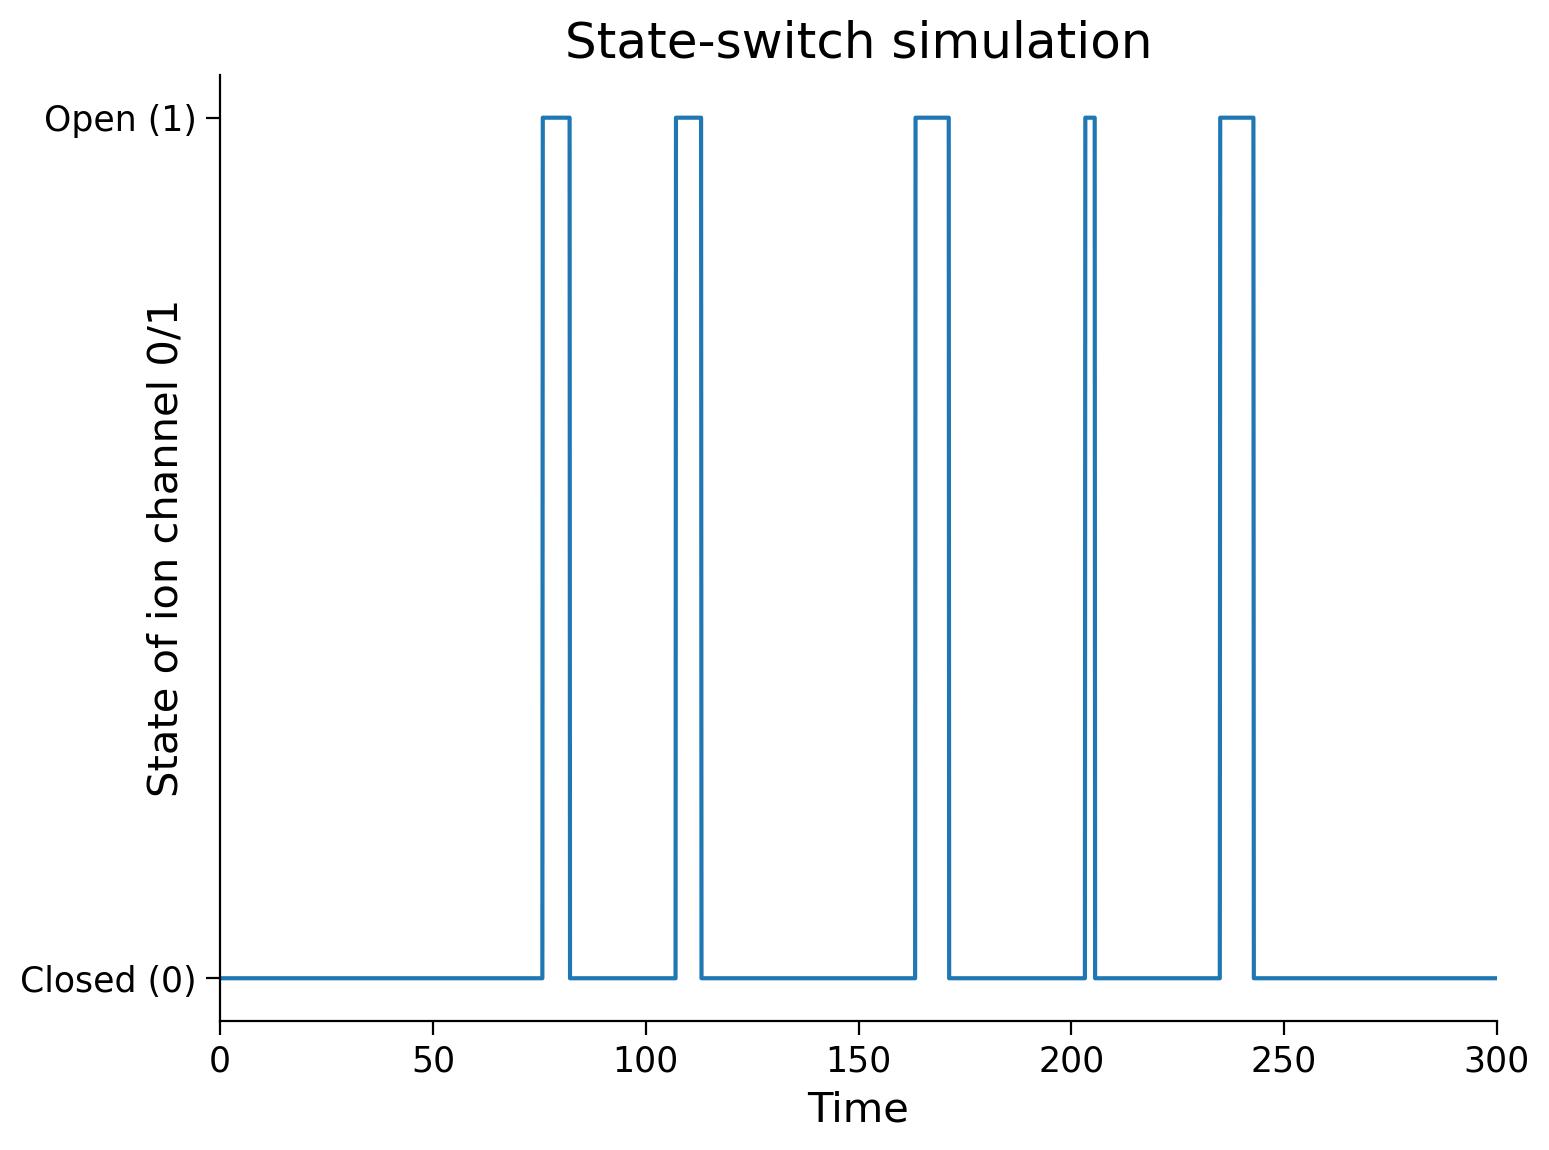

In [4]:
# @markdown Execute to simulate and plot state changes

# parameters
T = 5000     # total Time duration
dt = 0.001   # timestep of our simulation

# simulate state of our ion channel in time
# the two parameters that govern transitions are
# c2o: closed to open rate
# o2c: open to closed rate
def ion_channel_opening(c2o, o2c, T, dt):
  # initialize variables
  t = np.arange(0, T, dt)
  x = np.zeros_like(t)
  switch_times = []

  # assume we always start in Closed state
  x[0] = 0

  # generate a bunch of random uniformly distributed numbers
  # between zero and unity: [0, 1),
  # one for each dt in our simulation.
  # we will use these random numbers to model the
  # closed/open transitions
  myrand = np.random.random_sample(size=len(t))


  # walk through time steps of the simulation
  for k in range(len(t)-1):
    # switching between closed/open states are
    # Poisson processes
    if x[k] == 0 and myrand[k] < c2o*dt: # remember to scale by dt!
      x[k+1:] = 1
      switch_times.append(k*dt)
    elif x[k] == 1 and myrand[k] < o2c*dt:
      x[k+1:] = 0
      switch_times.append(k*dt)

  return t, x, switch_times


c2o = 0.02
o2c = 0.1
np.random.seed(0) # set random seed
t, x, switch_times = ion_channel_opening(c2o, o2c, T, .1)
plot_switch_simulation(t, x)

## Coding Exercise 1: Computing intervals between switches

*Referred to in video as exercise 2A*

We now have `switch_times`, which is a list consisting of times when the state switched. Using this, calculate the time intervals between each state switch and store these in a list called `inter_switch_intervals`.

We will then plot the distribution of these intervals. How would you describe the shape of the distribution?


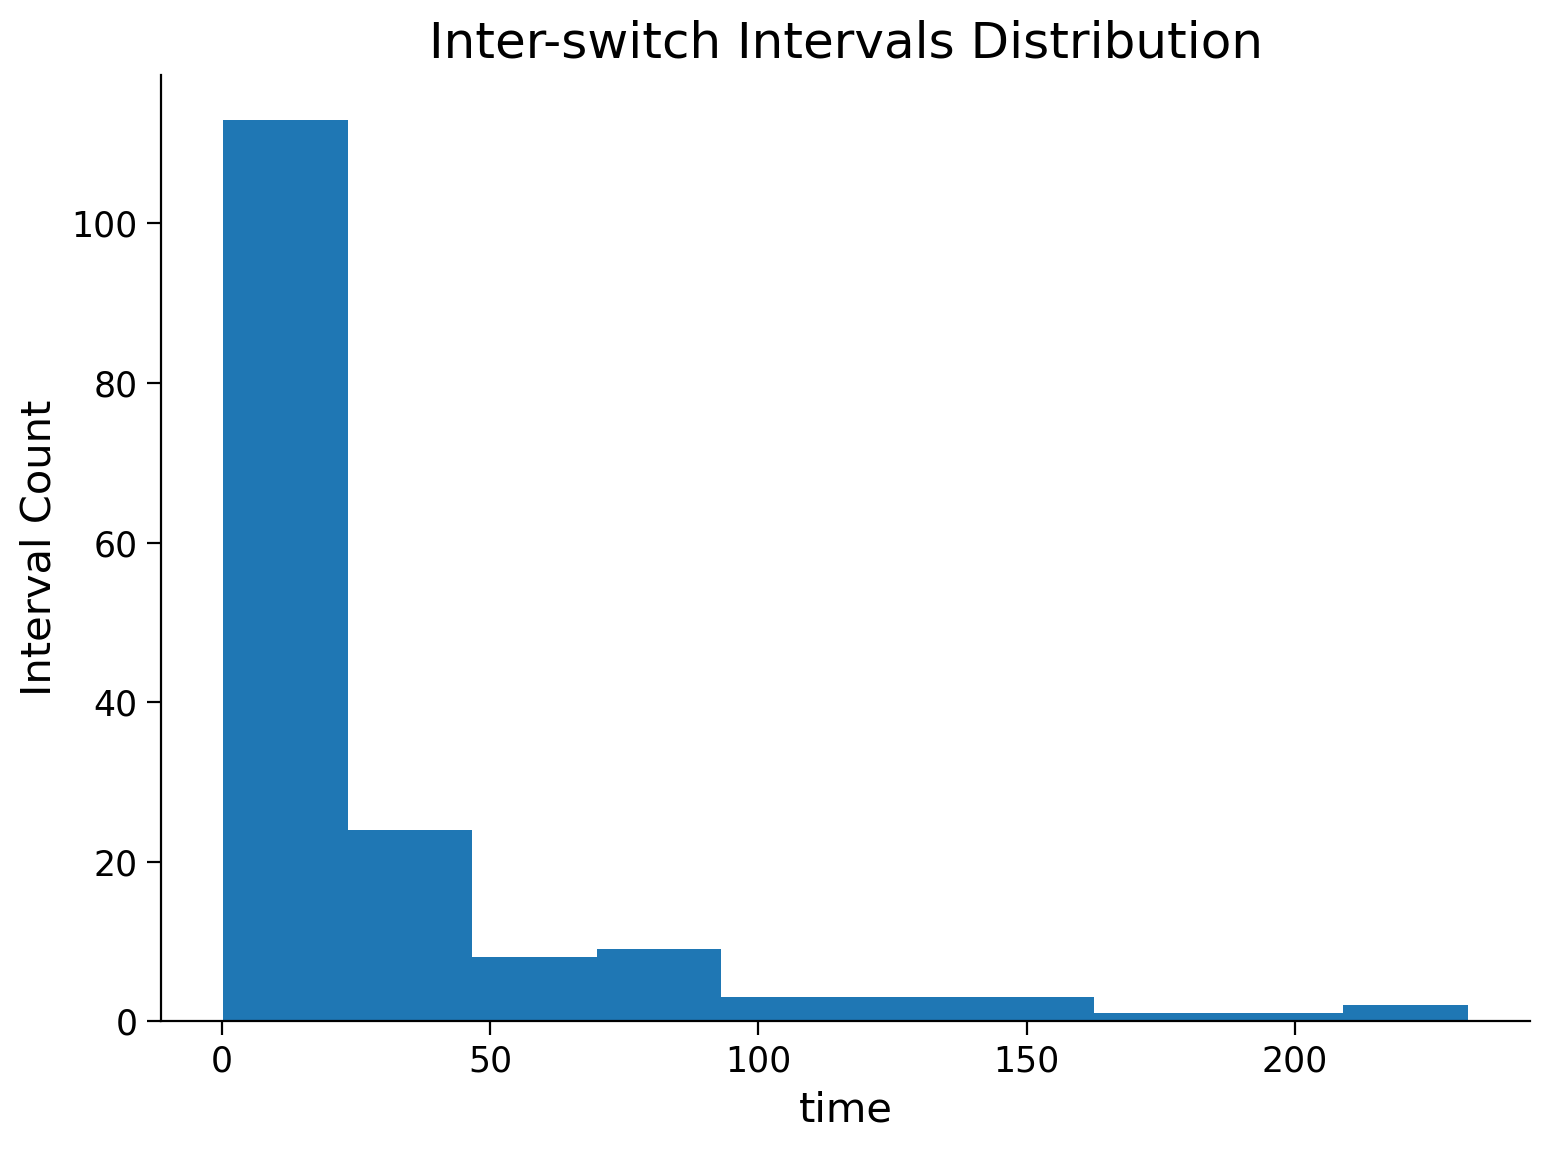

In [5]:
##############################################################################
## TODO: Insert your code here to calculate between-state-switch intervals
# raise NotImplementedError("Student exercise: need to calculate switch intervals")
##############################################################################

# hint: see np.diff()
inter_switch_intervals = np.diff(switch_times)

# plot inter-switch intervals
plot_interswitch_interval_histogram(inter_switch_intervals)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W2D2_LinearSystems/solutions/W2D2_Tutorial2_Solution_15275c81.py)

*Example output:*

<img alt='Solution hint' align='left' width=777.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W2D2_LinearSystems/static/W2D2_Tutorial2_Solution_15275c81_0.png>



In the next cell, we generate a bar graph to visualize the distribution of the number of time-steps spent in each of the two possible system states during the simulation.



 Execute cell to visualize distribution of time spent in each state.


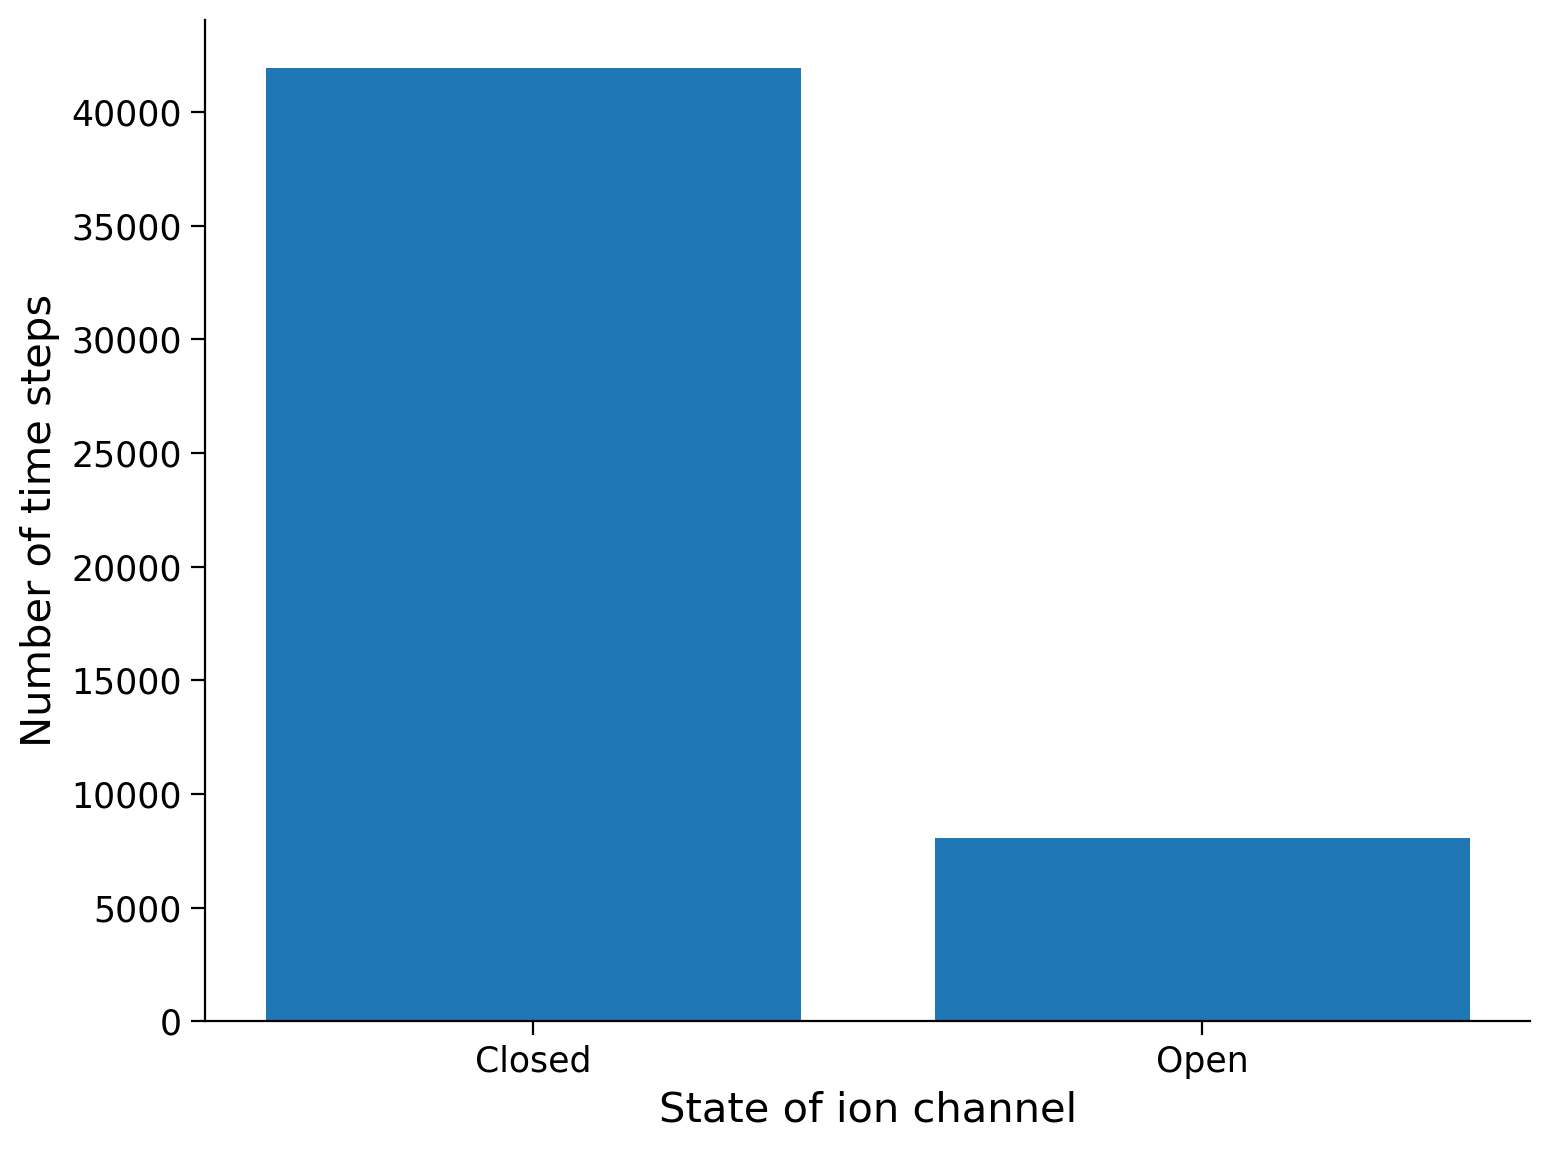

In [6]:
# @markdown Execute cell to visualize distribution of time spent in each state.

states = ['Closed', 'Open']
(unique, counts) = np.unique(x, return_counts=True)

plt.figure()
plt.bar(states, counts)
plt.ylabel('Number of time steps')
plt.xlabel('State of ion channel')
plt.show()

<!-- Though the system started initially in the Closed ($x=0$) state, over time, it settles into a equilibrium distribution where we can predict on what fraction of time it is Open as a function of the $\mu$ parameters.

Before we continue exploring these distributions further, let's first take a look at the this fraction of Open states as a cumulative mean of the state $x$: -->

Even though the state is _discrete_--the ion channel can only be either Closed or Open--we can still look at the **mean state** of the system, averaged over some window of time.

Since we've coded Closed as $x=0$ and Open as $x=1$, conveniently, the mean of $x$ over some window of time has the interpretation of **fraction of time channel is Open**.

Let's also take a look at the fraction of Open states as a cumulative mean of the state $x$. The cumulative mean tells us the average number of state-changes that the system will have undergone after a certain amount of time.

 Execute to visualize cumulative mean of state


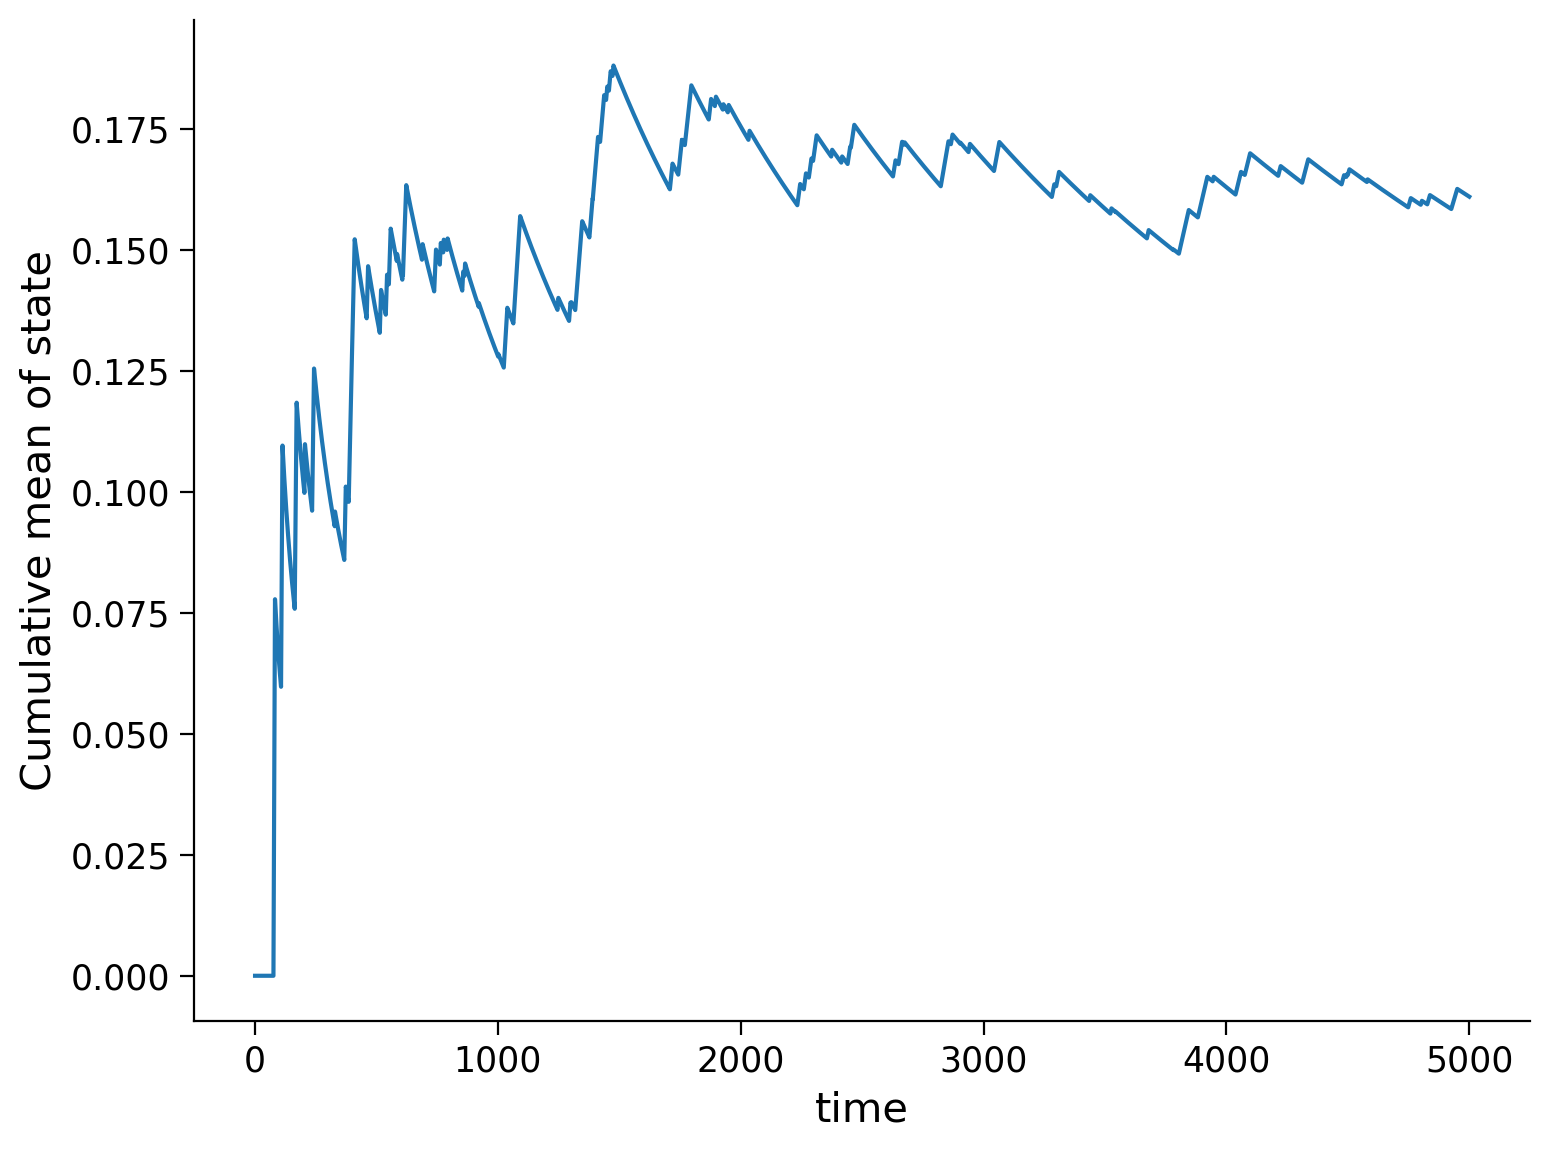

In [7]:
# @markdown Execute to visualize cumulative mean of state
plt.figure()
plt.plot(t, np.cumsum(x) / np.arange(1, len(t)+1))
plt.xlabel('time')
plt.ylabel('Cumulative mean of state')
plt.show()

Notice in the plot above that, although the channel started in the Closed ($x=0$) state, gradually adopted some mean value after some time. This mean value is related to the transition probabilities $\mu_{c2o}$
and $\mu_{o2c}$.

## Interactive Demo 1: Varying transition probability values & $T$

Using the interactive demo below, explore the state-switch simulation for different transition probability values of states $\mu_{c2o}$ and $\mu_{o2c}$. Also, try different values for total simulation time length $T$.

1.  Does the general shape of the inter-switch interval distribution change or does it stay relatively the same?
2.  How does the bar graph of system states change based on these values?

 Make sure you execute this cell to enable the widget!


In [8]:
# @markdown Make sure you execute this cell to enable the widget!

@widgets.interact
def plot_inter_switch_intervals(c2o=(0,1, .01), o2c=(0, 1, .01),
                                T=(1000, 10000, 1000)):

  t, x, switch_times = ion_channel_opening(c2o, o2c, T, .1)

  inter_switch_intervals = np.diff(switch_times)

  # plot inter-switch intervals
  plt.hist(inter_switch_intervals)
  plt.title('Inter-switch Intervals Distribution')
  plt.ylabel('Interval Count')
  plt.xlabel('time')
  plt.show()

interactive(children=(FloatSlider(value=0.0, description='c2o', max=1.0, step=0.01), FloatSlider(value=0.0, de…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W2D2_LinearSystems/solutions/W2D2_Tutorial2_Solution_88c4ce10.py)



---
# Section 2: Distributional Perspective

*Estimated timing to here from start of tutorial: 18 min*



This video serves as an introduction to the telegraph process of ion channels opening/closing with an alternative formulation as a matrix/vector representation of probabilistic state transitions.

<details>
<summary> <font color='blue'>Click here for text recap of video </font></summary>

We can run this simulation many times and gather empirical distributions of open/closed states. Alternatively, we can formulate the exact same system probabilistically, keeping track of the probability of being in each state.

<!-- Although the system started initially in the Closed ($x=0$) state, over time, it settles into a equilibrium distribution where we can predict on what fraction of time it is Open as a function of the $\mu$ parameters.  -->

(see diagram in lecture)

The same system of transitions can then be formulated using a vector of 2 elements as the state vector and a dynamics matrix $\mathbf{A}$. The result of this formulation is a *state transition matrix*:

\begin{equation}
\left[ \begin{array}{c} C \\ O \end{array} \right]_{k+1} = \mathbf{A} \left[ \begin{array}{c} C \\ O \end{array} \right]_k = \left[ \begin{array} & 1-\mu_{\text{c2o}} & \mu_{\text{o2c}} \\ \mu_{\text{c2o}} & 1-\mu_{\text{o2c}} \end{array} \right] \left[ \begin{array}{c} C \\ O \end{array} \right]_k.
\end{equation}

Each transition probability shown in the matrix is as follows:
1. $1-\mu_{\text{c2o}}$, the probability that the closed state remains closed.
2. $\mu_{\text{c2o}}$, the probability that the closed state transitions to the open state.
3.  $\mu_{\text{o2c}}$, the probability that the open state transitions to the closed state.
4. $1-\mu_{\text{o2c}}$, the probability that the open state remains open.

</details>

_Notice_ that this system is written as a discrete step in time, and $\mathbf{A}$ describes the transition, mapping the state from step $k$ to step $k+1$. This is different from what we did in the exercises above where $\mathbf{A}$ had described the function from the state to the time derivative of the state.

## Coding Exercise 2: Probability Propagation

*Referred to in video as exercise 2B*

Complete the code below to simulate the propagation of probabilities of closed/open of the ion channel through time. A variable called `x_kp1` (short for, $x$ at timestep $k$ plus 1) should be calculated per each step *k* in the loop. However, you should plot $x$.

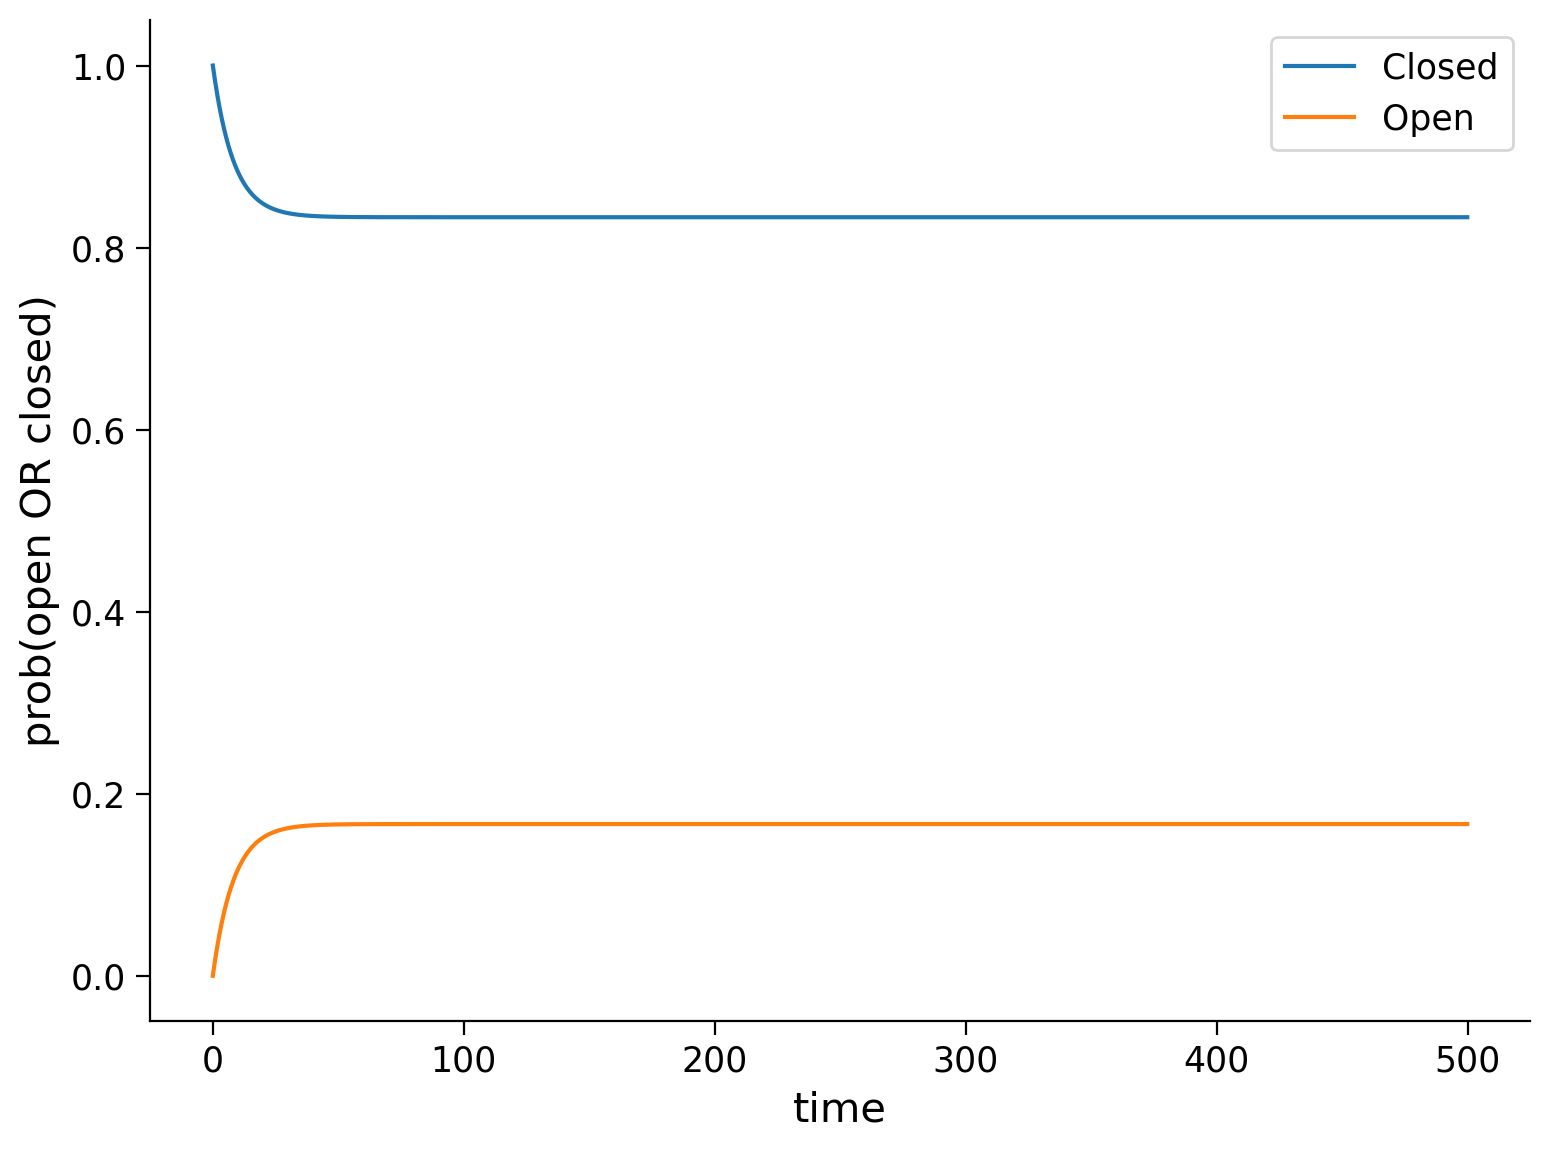

In [9]:
def simulate_prob_prop(A, x0, dt, T):
  """ Simulate the propagation of probabilities given the transition matrix A,
  with initial state x0, for a duration of T at timestep dt.

  Args:
    A (ndarray): state transition matrix
    x0 (ndarray): state probabilities at time 0
    dt (scalar): timestep of the simulation
    T (scalar): total duration of the simulation

  Returns:
    ndarray, ndarray: `x` for all simulation steps and the time `t` at each step
  """

  # Initialize variables
  t = np.arange(0, T, dt)
  x = x0 # x at time t_0

  # Step through the system in time
  for k in range(len(t)-1):
    ###################################################################
    ## TODO: Insert your code here to compute x_kp1 (x at k plus 1)
    # raise NotImplementedError("Student exercise: need to implement simulation")
    ## hint: use np.dot(a, b) function to compute the dot product
    ##       of the transition matrix A and the last state in x
    ## hint 2: use np.vstack to append the latest state to x
    ###################################################################

    # Compute the state of x at time k+1
    x_kp1 = A @ x[k]

    # Stack (append) this new state onto x to keep track of x through time steps
    x = np.vstack([x, x_kp1])

  return x, t


# Set parameters
T = 500     # total Time duration
dt = 0.1   # timestep of our simulation

# same parameters as above
# c: closed rate
# o: open rate
c = 0.02
o = 0.1
A = np.array([[1 - c*dt, o*dt],
              [c*dt,     1 - o*dt]])

# Initial condition: start as Closed
x0 = np.array([[1, 0]])

# Simulate probabilities propagation
x, t = simulate_prob_prop(A, x0, dt, T)

# Visualize
plot_state_probabilities(t, x)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W2D2_LinearSystems/solutions/W2D2_Tutorial2_Solution_41ec6e01.py)

*Example output:*

<img alt='Solution hint' align='left' width=778.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W2D2_LinearSystems/static/W2D2_Tutorial2_Solution_41ec6e01_0.png>



Here, we simulated the propagation of probabilities of the ion channel's state changing through time. Using this method is useful in that we can **run the simulation once** and see **how the probabilities propagate throughout time**, rather than re-running and empirically observing the telegraph simulation over and over again.

Although the system started initially in the Closed ($x=0$) state, over time, it settles into a equilibrium distribution where we can predict what fraction of time it is Open as a function of the $\mu$ parameters. We can say that the plot above shows this _relaxation towards equilibrium_.

Re-calculating our value of the probability of $c2o$ again with this method, we see that this matches the simulation output from the telegraph process!



In [10]:
print(f"Probability of state c2o: {(c2o / (c2o + o2c)):.3f}")

Probability of state c2o: 0.167


---
# Section 3: Equilibrium of the telegraph process

*Estimated timing to here from start of tutorial: 30 min*

Since we have now modeled the propagation of probabilities by the transition matrix $\mathbf{A}$ in Section 2, let's connect the behavior of the system at equilibrium with the eigendecomposition of $\mathbf{A}$.

As introduced in the lecture video, the eigenvalues of $\mathbf{A}$ tell us about the stability of the system, specifically in the directions of the corresponding eigenvectors.

In [11]:
# compute the eigendecomposition of A
lam, v = np.linalg.eig(A)

# print the 2 eigenvalues
print(f"Eigenvalues: {lam}")

# print the 2 eigenvectors
eigenvector1 = v[:, 0]
eigenvector2 = v[:, 1]
print(f"Eigenvector 1: {eigenvector1}")
print(f"Eigenvector 2: {eigenvector2}")

Eigenvalues: [1.    0.988]
Eigenvector 1: [0.98058068 0.19611614]
Eigenvector 2: [-0.70710678  0.70710678]


In [13]:
eigenvector1/sum(eigenvector1)

array([0.83333333, 0.16666667])

## Think! 3: Finding a stable state

1.  Which of these eigenvalues corresponds to the **stable** (equilibrium) solution?
2.  What is the eigenvector of this eigenvalue?
3.  How does that explain the equilibrium solutions in simulation in Section 2 of this tutorial?

_hint_: our simulation is written in terms of probabilities, so they must sum to 1. Therefore, you may also want to rescale the elements of the eigenvector such that they also sum to 1. These can then be directly compared with the probabilities of the states in the simulation.

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W2D2_LinearSystems/solutions/W2D2_Tutorial2_Solution_37abbdad.py)



---
# Summary

*Estimated timing of tutorial: 45 minutes*


In this tutorial, we learned:

* The definition of a Markov process with history dependence.
* The behavior of a simple 2-state Markov process --the telegraph process-- can be simulated either as a state-change simulation or as a propagation of probability distributions.
* The relationship between the stability analysis of a dynamical system expressed either in continuous or discrete time.
* The equilibrium behavior of a telegraph process is predictable and can be understood using the same strategy as for deterministic systems in Tutorial 1: by taking the eigendecomposition of the $\mathbf{A}$ matrix.